# Project 2: Implementing a Simple Convolutional Neural Network (CNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project!  (Note, however, that your work should not simply mirror models already covered in the course, nor published works of others.) Kaggle would be a good source to look for datasets. Below are some examples that we have already seen, which would be of an appropriate nature; you might tackle these (with your own approach), or choose a different dataset:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


# CIFAR‑10 Classification with PyTorch
This notebook walks through training a Convolutional Neural Network (CNN) on the CIFAR‑10 dataset (60 000 32×32 RGB images across 10 classes). 

## 1. Setup & Imports
We start by importing PyTorch, `torchvision` for the dataset and transforms, and `tqdm` for progress bars.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Preparation
* **Transforms** – We normalize pixel values to `[-1, 1]` and apply random horizontal flips for slight augmentation.

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),                               #Used Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),                               #Used Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
test_set  = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

In [3]:
classes = train_set.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


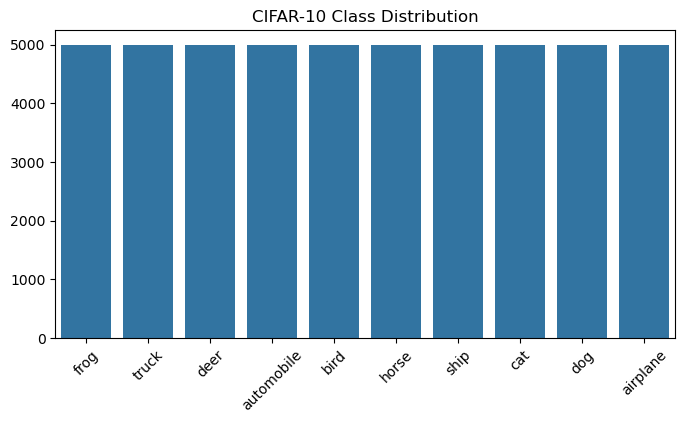

In [4]:
from collections import Counter

labels = [label for _, label in train_set]
class_counts = Counter(labels)

plt.figure(figsize=(8, 4))
sns.barplot(x=[classes[i] for i in class_counts.keys()], y=list(class_counts.values()))
plt.title("CIFAR-10 Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [5]:
loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=False)

mean = 0.0
std = 0.0
nb_samples = 0

for data in loader:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Channel-wise Mean: {mean}")
print(f"Channel-wise Std: {std}")


Channel-wise Mean: tensor([-0.0172, -0.0357, -0.1069])
Channel-wise Std: tensor([0.4046, 0.3988, 0.4019])


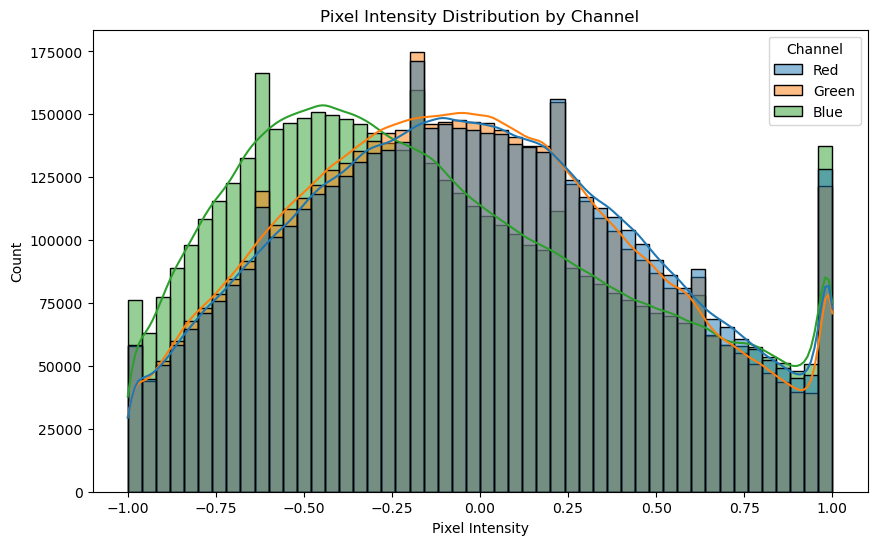

In [6]:
import pandas as pd

def plot_channel_distribution(dataset, n_samples=5000):
    red, green, blue = [], [], []
    for i in range(n_samples):
        img, _ = dataset[i]
        r, g, b = img[0].flatten(), img[1].flatten(), img[2].flatten()
        red.extend(r.numpy())
        green.extend(g.numpy())
        blue.extend(b.numpy())

    df = pd.DataFrame({'Red': red, 'Green': green, 'Blue': blue})
    df_melted = df.melt(var_name='Channel', value_name='Pixel Intensity')

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_melted, x='Pixel Intensity', hue='Channel', bins=50, kde=True)
    plt.title("Pixel Intensity Distribution by Channel")
    plt.show()

plot_channel_distribution(train_set)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping inp

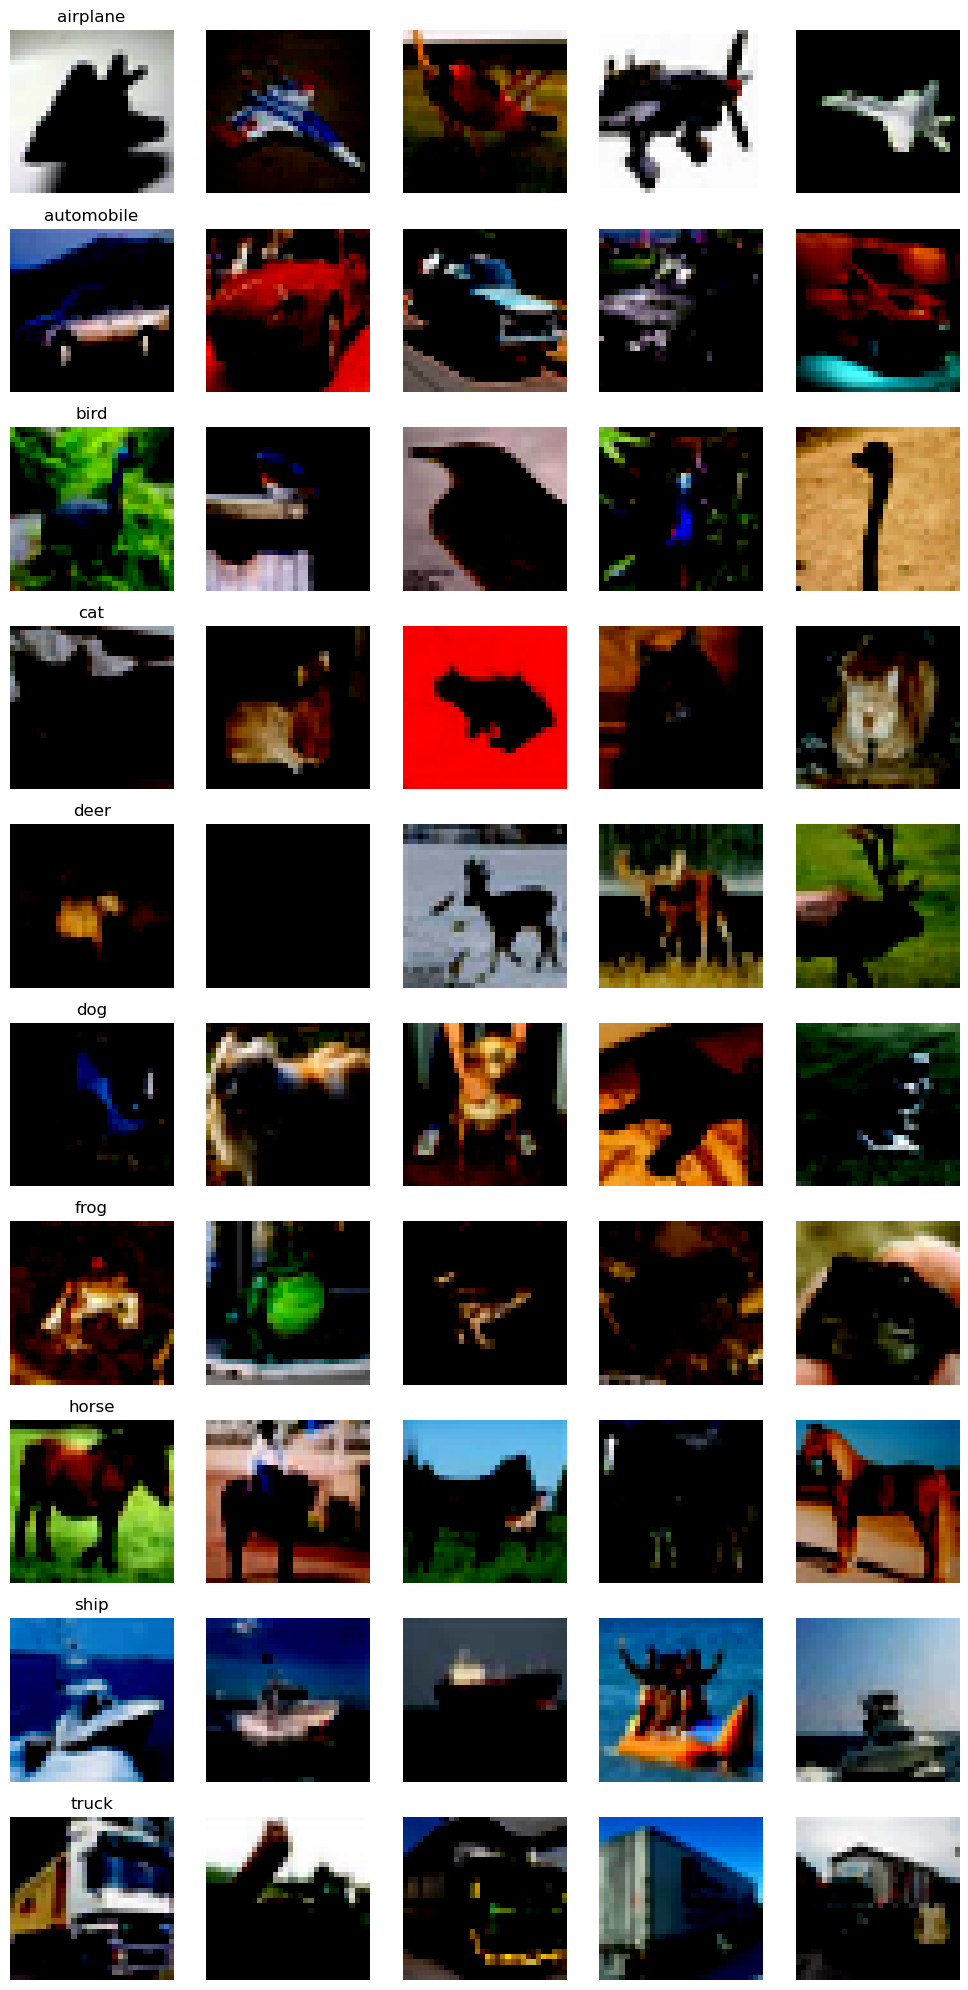

In [8]:
def show_samples_per_class(dataset, classes, samples=5):
    fig, axes = plt.subplots(len(classes), samples, figsize=(samples*2, len(classes)*2))
    class_idx_map = {cls: [] for cls in range(len(classes))}

    for img, label in dataset:
        if len(class_idx_map[label]) < samples:
            class_idx_map[label].append(img)

    for i, (label, imgs) in enumerate(class_idx_map.items()):
        for j, img in enumerate(imgs):
            axes[i, j].imshow(np.transpose(img.numpy(), (1, 2, 0)))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(classes[label])

    plt.tight_layout()
    plt.show()
import numpy as np

show_samples_per_class(train_set, classes)


## 3. Define the CNN Model
A lightweight architecture: three convolutional blocks followed by two fully‑connected layers. Dropout is included to reduce overfitting.

In [10]:
class CifarCNN(nn.Module):
    def __init__(self, dropout=0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32×32
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 16×16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 8×8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),  # 4×4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

## 4. Training & Evaluation Helpers
Utility functions for one training epoch and evaluation on the validation set.

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc='Train', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Eval', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return loss_total / total, correct / total

## 5. Training Loop
We instantiate the model, loss function, and optimizer, then train for **10 epochs**. Accuracy and loss for both training and test sets are printed each epoch.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CifarCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
history = {'train_acc': [], 'test_acc': []}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    print(f"Epoch {epoch}/{EPOCHS} • Train Acc: {train_acc*100:.2f}% • Test Acc: {test_acc*100:.2f}%")

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10 • Train Acc: 58.22% • Test Acc: 70.62%


Epoch 2/10 • Train Acc: 72.23% • Test Acc: 73.86%


Epoch 3/10 • Train Acc: 76.95% • Test Acc: 78.82%


Epoch 4/10 • Train Acc: 79.89% • Test Acc: 79.53%


Epoch 5/10 • Train Acc: 82.33% • Test Acc: 81.17%


Epoch 6/10 • Train Acc: 84.10% • Test Acc: 80.97%


Epoch 7/10 • Train Acc: 85.90% • Test Acc: 81.92%


Epoch 8/10 • Train Acc: 86.84% • Test Acc: 82.13%


Epoch 9/10 • Train Acc: 88.08% • Test Acc: 82.10%


Epoch 10/10 • Train Acc: 89.33% • Test Acc: 82.60%


### Accuracy Trend

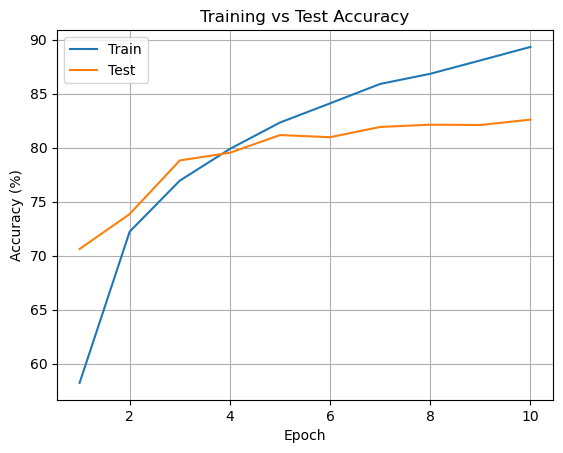

In [13]:
plt.plot(range(1, EPOCHS + 1), [a*100 for a in history['train_acc']], label='Train')
plt.plot(range(1, EPOCHS + 1), [a*100 for a in history['test_acc']], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 6. Save the Trained Model
Persist the best-performing model weights so you can reload them later.

In [14]:
torch.save(model.state_dict(), 'cifar10_cnn.pth')
print('Model saved to cifar10_cnn.pth')

Model saved to cifar10_cnn.pth


---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.

A CNN is a deep-learning architecture designed to learn spatial hierarchies of features from grid-like data (e.g., images, audio spectrograms).Components of Convolutional Neural Network (CNN) are as follows:
a) Convolutional layer - Convolutional layer Sliding through the input with learnable filters (kernels) and generating feature maps and identifying local patterns (edges, textures, and so on). In FC layers all neurons are connected to all input units parameters.

b) Activation Function - Activation Adds non-linearity, usually using some type of activation (e.g. ReLU) to allow the network to represent complex functions. Identical to FC nets except applied on an element level to feature maps.

c) Pooling - Pooling / Sub-sampling Down-samples feature maps such that they have reduced spatial resolution to be invariant to small translations as well as to reduce computations. There is no direct legal analogy in normal FC nets.
d) Batch Normalization - Normalization (Batch/Layer Norm) helps training to be stable, it keeps activations within sane numbers. Likewise FC nets, except feature maps are normalised in place of the channel and spatial dims.

e) Fully Connected head - Fully connected head The high level features are flattened after several conv blocks, and input into FC layers to do final classification/regression. The same in concept, only this time they observe abstractions of features instead of naked pixels.


2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?

It provides local pattern extraction with weight sharing.    The kernels finds at just 9 neighbouring pixels, learning detectors like edges,, corner, color blobs. Because the same kernel slides across the whole image, the network recognises a pattern wherever it occurs. 
a) 1X1 - Mixes information across channels but not space; great for dimensionality reduction.
b) 3X3 - Captures fine-grained local patterns while keeping parameters low. Two stacked 3 × 3 layers give an effective 5 × 5 receptive field.
c) 5X5, 7X7 - Capture broader context but add parameters and FLOPs. Often replaced by stacks of 3 × 3s or dilated convolutions for efficiency.




3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?

Purpose of a pooling layer are as follows:
- Reduces wdth and height so later layers operate on smaller maps.
- Max-pool keeps the strongest activation withina window, making the eexact feature position less critical.
- It helps in regulatization by applying fewer activation which leads to smaller subsequen layers and less risk of overfitting.


4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.

Activation functions are important in CNN to introduce non-linearity which can learn complex pattern and without it convolutions would not work in a linear to transformations.

-Sigmoid functions - Sigmoid will produce the values in 0 to 1  and hence can be used in binary classification tasks. The problem with it though, is that it can be affected by the vanishing gradient problem, particularly in deep networks, whereby gradients can become extremely small during backpropagation, and can make learning slow.

- Tanh - Just like sigmoid, tanh is also sigmoidal in shape with the output usually around -1 to 1. Although, unlike sigmoid, it is impervious to negative inputs, it still suffers the same problem of the vanishing gradient, especially in deep networks.

- ReLU - ReLU solves the vanishing gradient issue by simply giving the input directly as output in case of non-negative input, and zero in case otherwise. This is on the one hand enables quicker training than sigmoid and tanh, particularly in the case of deep networks. Nonetheless, ReLU are vulnerable to what is known as the problem of dying ReLU whereby neurons may become idle and cease learning when they always produce the value zero.




5. Describe the process of training a CNN. What are some common challenges faced during training?

The Process involves following processes:
1. Data Preparation - 
- Collecting and Labelling-
Get a pertinent dataset and provide every picture with the password of a specific type (e.g., cat or dog).
- Preprocessing:
Image preparation consists of converting image to CNN format by resizing, normalization of images and possible augmenting using rotations, flips. This is able to enhance model performance and avoid overfitting.
- Splitting:
Split the dataset into test, validation and training sets. The training set is meant to be used to train the model, the validation set to observe performance through training and the test set to evaluate the final model.

2. Model Definition:
- Architecture: CNN architecture. It includes the selection of the number, type of the layers (convolutional, pooling, fully connected, etc.).
- Convolutional Layers: The convolutional layers utilize filters to bring out features on the image that is input.
- Pooling Layers: These are layers that bring about a reduction of spatial dimensions of the feature maps.
- Activation Function: The concept of non-linearity is achieved by implementing non-linear functions such as ReLU.
- Fully Connected Layers: These are the layers that are usually at the end of the network and it is the job of the layers to make the prediction by use of features which have been extracted.
3. Training:
- Optimizer: Select an optimization method (e.g., Adam, SGD) to adjust weights concerning the model.
- Loss Function: Choose a loss (e.g. cross-entropy) that would quantify the discrepancies between the prediction produced by a model and the real labels.
- Training Loop: Go over the training data, passing batches of images into the CNN.
- Forward Pass: The CNN is fed with imageries in order to make the predictions.
- Backpropagation: Compute the gradient of the loss function with regard to the weights of the model.
- Weight Update: Update the weights of the model based upon the optimizer and the obtained gradients.
4. Evaluation:
- Validation Set:
Track the model performances on the validation set when training. This aids in identification of overfitting and fine tuning hyper parameters.
- Test Set:
After the completion of training, we can measure the performance of the model on unseen test set to evaluate the capability of generalization.

Some Challenges are as follows :
- Vanishing / exploding gradients - fixed by ReLU, batch-norm, scrupulous weight forms, and closing connections.

- Overfitting Overfitting was addressed through data augmentation, dropout, weight decay and use of larger datasets.

- Imbalance of classes - weighted loss, focal loss or resampling.

- Computational; it is memory/FLOPs demanding; it can be addressed with mixed-precision training, model shrinking, pruning, and quantisation.


6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
- Accuracy – % of correctly classified samples (most common).

- Top-k accuracy – Especially for datasets with many classes (e.g., ImageNet) — did the correct label appear in the top-k predictions?

- Precision / Recall / F1-score – Useful when classes are imbalanced.

- Confusion matrix – Visualises per-class performance.

- AUC-ROC / PR-AUC – For tasks where you treat each class as a one-vs-rest problem.



7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.

Augmentation synthetically expands the training set by applying label-preserving transformations, helping the model generalise to real-world variations and reducing overfitting.
Some of the common techniques to augment data are as follows:
- Random crop/resize, horizontal or vertical flip, small rotations, translations, perspective warp, cutout.
- Colour jitter (brightness, contrast, saturation, hue), Gaussian noise, blurring, sharpening.
